In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


import torchvision.transforms as transforms
from PIL import Image

In [6]:
# Define image resolution (change this for larger images)
IMG_SIZE = 512  # Change to 1024 or higher if needed

# Load and preprocess the image
image_path = "halftone_face.jpg"  # Replace with your image file
image = Image.open(image_path).convert("RGB")  # Convert to RGB if not already

# Transform: Resize to high resolution, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to high resolution
    transforms.ToTensor(),  # Convert to tensor (C, H, W)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
original_image = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)

print(f"Image shape: {original_image.shape}")  # Should print (1, 3, IMG_SIZE, IMG_SIZE)

class DeepAutoencoder(nn.Module):
    def __init__(self):
        super(DeepAutoencoder, self).__init__()
        
        # Encoder: Downsampling using Conv layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # (C, H, W) -> (32, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (32, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # (64, H/8, W/8)
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # (128, H/16, W/16)
            nn.ReLU(),
        )
        
        # Decoder: Upsampling using Transposed Conv layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # (128, H/8, W/8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # (64, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (32, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),  # (3, H, W)
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
model = DeepAutoencoder()

Image shape: torch.Size([1, 3, 512, 512])


In [ ]:
# Define the MSE loss function
loss_fn = nn.MSELoss()

# Custom optimization step to maximize loss
def minimize_loss_step(model, optimizer, original_image):
    optimizer.zero_grad()
    reconstructed_image = model(original_image)
    loss = loss_fn(reconstructed_image, original_image)
    (loss).backward() 
    optimizer.step()
    return loss.item()

def maximize_loss_step(model, optimizer, original_image):
    optimizer.zero_grad()
    reconstructed_image = model(original_image)
    loss = loss_fn(reconstructed_image, original_image)
    (-loss).backward()  # Negate the loss to maximize it
    optimizer.step()
    return loss.item()

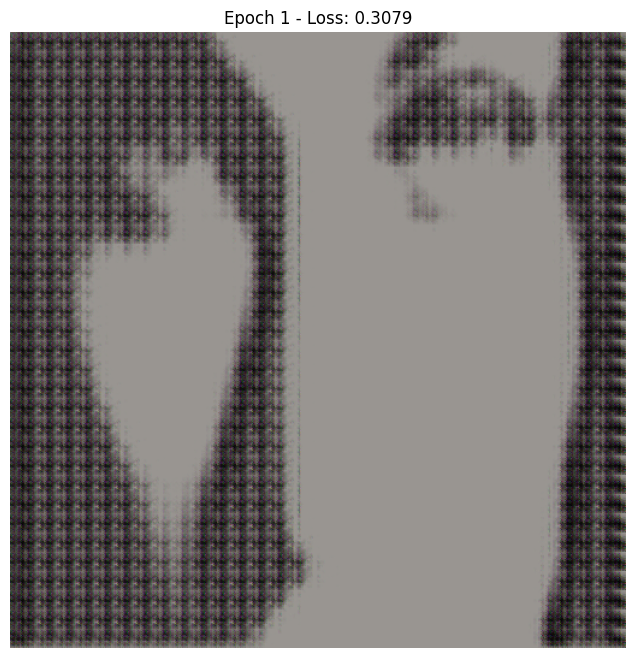

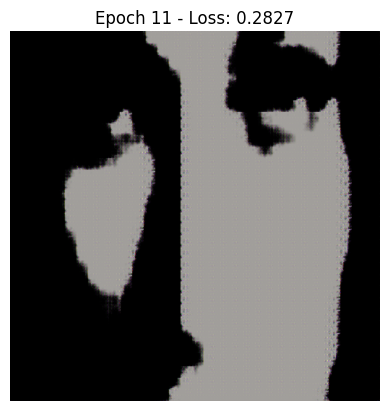

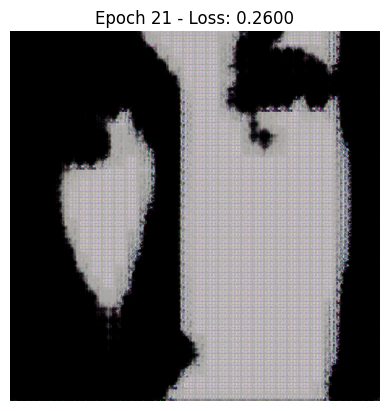

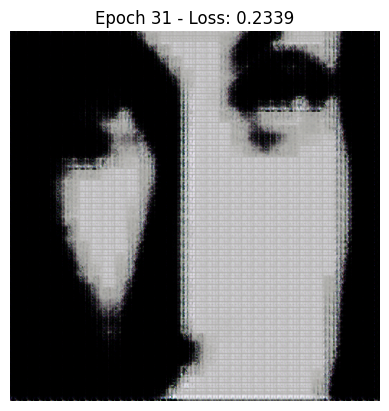

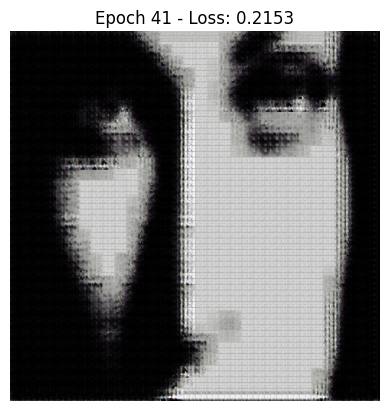

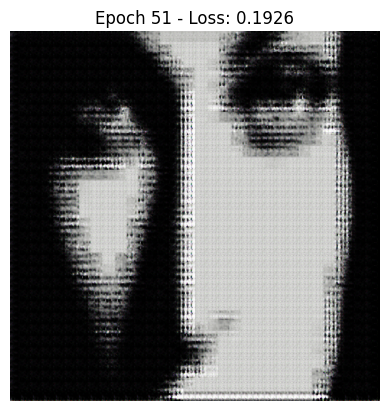

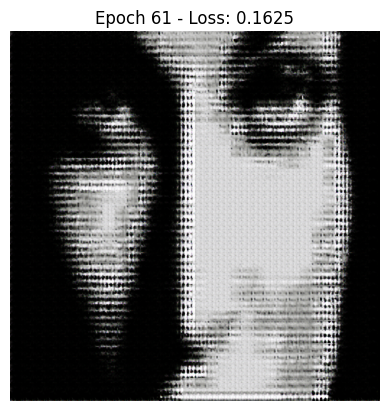

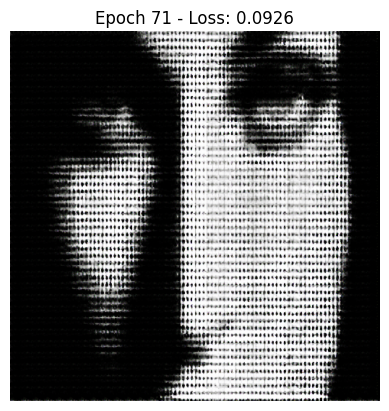

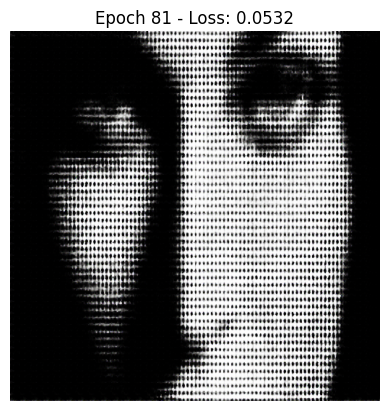

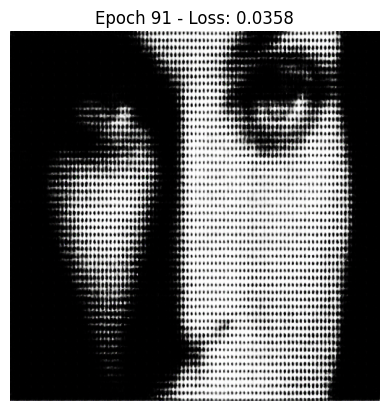

Training complete.


In [8]:
# Standard loss minimalization
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of training epochs
num_epochs = 100
losses = []

# Denormalize the images for visualization
def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

# Initialize the plot
plt.figure(figsize=(8, 8))

for epoch in range(num_epochs):
    loss = minimize_loss_step(model, optimizer, original_image)
    losses.append(loss)

    if epoch % 10 == 1:
        # print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
        # Reconstruct the image using the trained model
        with torch.no_grad():
            reconstructed_image = model(original_image).squeeze(0) 
        
        # Convert tensors to NumPy for visualization
        original_image_np = denormalize(original_image.squeeze(0)).permute(1, 2, 0).numpy()
        reconstructed_image_np = denormalize(reconstructed_image.squeeze(0)).permute(1, 2, 0).numpy()

        # Display the reconstructed image
        plt.imshow(reconstructed_image_np)
        plt.title(f"Epoch {epoch} - Loss: {loss:.4f}")
        plt.axis("off")

        # Update plot
        plt.pause(0.1)  # Pause to allow updates

print("Training complete.")
plt.show()  # Keep the final image displayed

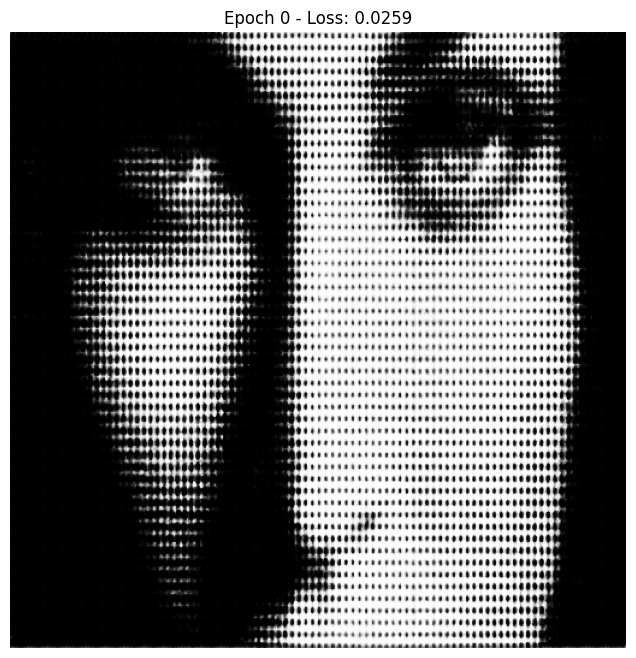

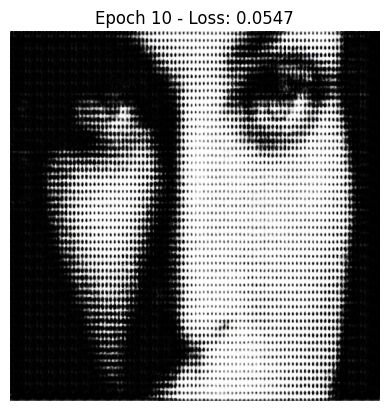

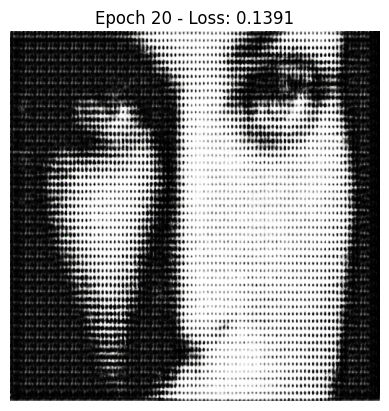

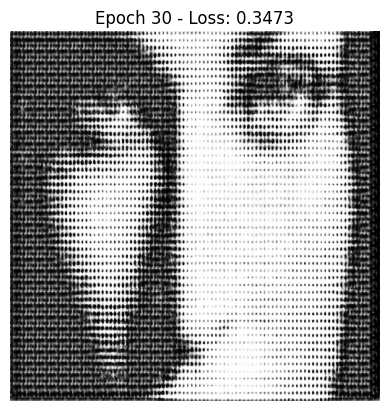

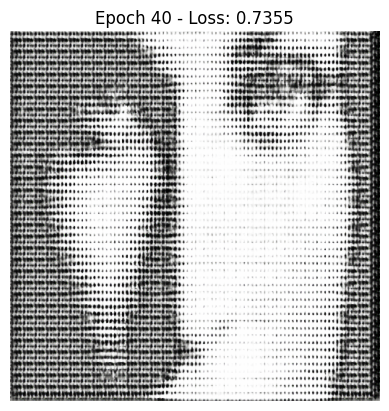

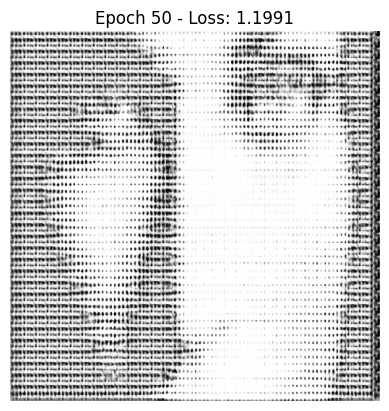

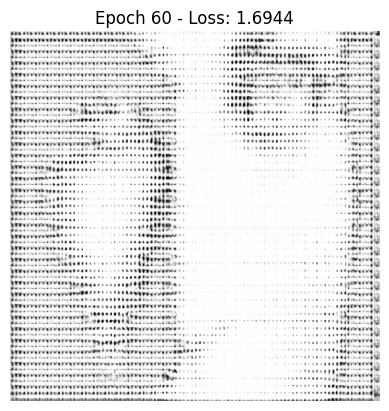

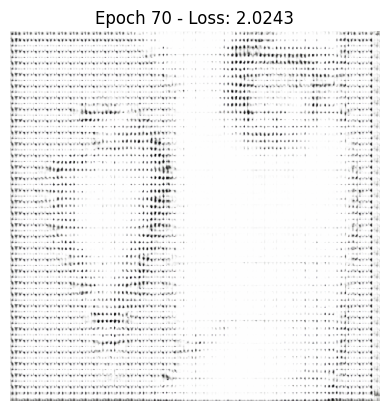

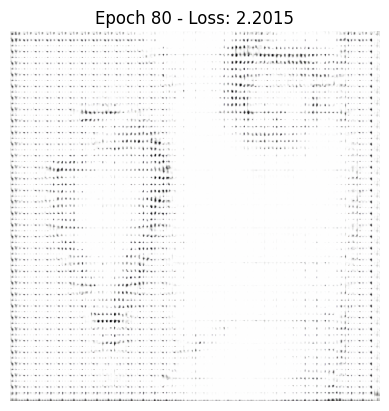

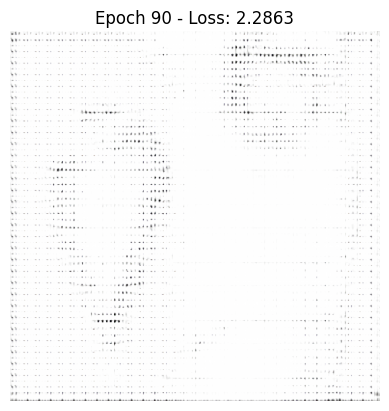

Training complete.


In [9]:
# Try maximizing loss instead
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Number of training epochs
num_epochs = 100
losses = []

# Denormalize the images for visualization
def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

# Initialize the plot
plt.figure(figsize=(8, 8))

for epoch in range(num_epochs):
    loss = maximize_loss_step(model, optimizer, original_image)
    losses.append(loss)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
        # Reconstruct the image using the trained model
        with torch.no_grad():
            reconstructed_image = model(original_image).squeeze(0) 
        
        # Convert tensors to NumPy for visualization
        original_image_np = denormalize(original_image.squeeze(0)).permute(1, 2, 0).numpy()
        reconstructed_image_np = denormalize(reconstructed_image.squeeze(0)).permute(1, 2, 0).numpy()

        # Display the reconstructed image
        plt.imshow(reconstructed_image_np)
        plt.title(f"Epoch {epoch} - Loss: {loss:.4f}")
        plt.axis("off")

        # Update plot
        plt.pause(0.1)  # Pause to allow updates

print("Training complete.")
plt.show()  # Keep the final image displayed
